<a href="https://colab.research.google.com/github/ravi-gopalan/ipl_analysis/blob/master/ipl_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 May 31 16:17 .
drwxr-xr-x 1 root root 4096 Jun  7 01:35 ..
drwxr-xr-x 1 root root 4096 May 31 16:17 .config
drwxr-xr-x 1 root root 4096 May 31 16:17 sample_data


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content

/content


In [0]:
!mkdir ipl

In [5]:
cd /content/ipl

/content/ipl


In [7]:
cd /root

/root


In [0]:
!mkdir .kaggle

In [0]:
!cp '/content/gdrive/My Drive/Colab_stuff/kaggle.json' /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
cd /content/ipl

/content/ipl


In [9]:
!cp -v /content/ipl.zip /content/ipl/ipl.zip

'/content/ipl.zip' -> '/content/ipl/ipl.zip'


In [10]:
cd /content/ipl

/content/ipl


In [11]:
!kaggle datasets download -d ravijee/ipl-2008-to-2019 -p /content/ipl

  0% 0.00/1.97M [00:00<?, ?B/s]
100% 1.97M/1.97M [00:00<00:00, 65.3MB/s]


In [12]:
!ls -la

total 2024
drwxr-xr-x 2 root root    4096 Jun  7 01:53 .
drwxr-xr-x 1 root root    4096 Jun  7 01:38 ..
-rw-r--r-- 1 root root 2060580 Jun  7 01:53 ipl-2008-to-2019.zip


In [15]:
pwd

'/content/ipl'

In [0]:
!unzip -q /content/ipl/ipl-2008-to-2019.zip

In [18]:
!pip install ruamel.yaml

     |████████████████████████████████| 665kB 9.5MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ruamel.yaml import YAML
import json
import datetime as dt

In [0]:
base_dir = Path('/content/ipl')

In [0]:
yaml_file_list = list(Path(base_dir).glob('*.yaml'))

In [0]:
def myconverter(o):
    if isinstance(o, dt.date):
        return o.__str__()

In [0]:
def create_data_frame_from_innings_dict(datafile_json, inning_number, innings_dict):
  df_innings=pd.DataFrame({'col':datafile_json['innings'][inning_number][innings_dict]['deliveries']})
  df_T = df_innings['col'].apply(pd.Series).T
  df_T['main'] = df_T[df_T.columns].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
  df_next = df_T.filter(['main'])
  df_next['main'] = df_next['main'].apply(lambda x : eval(x)) 
  df_next_2 = df_next['main'].apply(pd.Series)
  df_next_try = df_next_2.filter(['batsman','bowler','non_striker','runs','wicket','extras'])

  df_runs = df_next_try[['runs']]
  df_run_details = df_runs['runs'].apply(pd.Series)
  
  if 'wicket' in df_next_try.columns:
    df_wickets = df_next_try[['wicket']]
    df_wicket_details = df_wickets['wicket'].apply(pd.Series)
  else:
    df_wicket_details = pd.DataFrame(columns=['fielders', 'kind', 'player_out'])   
         
  if 'extras' in df_next_try.columns:
    df_extras = df_next_try[['extras']]
    df_extras_details = df_extras['extras'].apply(pd.Series)
  else:
    df_extras_details = pd.DataFrame(columns=['0', 'wides', 'legbyes'])
    
  drop_column_list = ['runs']

  if 'wicket' in df_next_try.columns:
    drop_column_list.append('wicket')

  if 'extras' in df_next_try.columns:
    drop_column_list.append('extras')
  
  df = df_next_try.join(df_run_details,rsuffix='_runs').join(df_wicket_details,rsuffix='_wickets').join(df_extras_details,rsuffix='_extras').drop(columns=drop_column_list)
  df['batting_team'] = datafile_json['innings'][inning_number][innings_dict]['team']
  
  return df


In [0]:
def create_data_frame_from_info_dict(datafile_json):
  info = pd.DataFrame({'info':datafile_json['info']}).T
  outcome = info['outcome'].apply(pd.Series)
  toss = info['toss'].apply(pd.Series)
  match_summary = info.join(outcome,rsuffix='_outcome').join(toss, rsuffix='_toss').drop(columns=['outcome','toss'])
  return match_summary

In [25]:
len(yaml_file_list)

756

In [26]:
counter = 0
info_list = []
ball_by_ball_details = []
for each_file in range(len(yaml_file_list)):
  in_file = yaml_file_list[each_file]
  out_file = 'output.json'


  tyaml = YAML(typ='safe')
  with open(in_file) as fpi:
      data_yaml = tyaml.load(fpi)
  with open(out_file, 'w') as fpo:
      json.dump(data_yaml, fpo, default=myconverter)
    
  with open(out_file, 'r') as f:
      json_file = json.load(f)
      
      
  if len(json_file['innings']) == 2:
    d1 = create_data_frame_from_innings_dict(datafile_json=json_file, inning_number=0, innings_dict='1st innings')
    d2 = create_data_frame_from_innings_dict(datafile_json=json_file, inning_number=1, innings_dict='2nd innings')
    df_match = pd.concat([d1, d2], keys=['inning_1', 'inning_2']).reset_index()
  elif len(json_file['innings']) == 1:
    d1 = create_data_frame_from_innings_dict(datafile_json=json_file, inning_number=0, innings_dict='1st innings')
    d2 = pd.DataFrame()
    df_match = pd.concat([d1, d2], keys=['inning_1', 'inning_2']).reset_index()
  else:
    df_match = pd.DataFrame()
  
  df_match['match_id'] = yaml_file_list[each_file].stem
  match_info_summary = create_data_frame_from_info_dict(datafile_json=json_file)
  
  match_info_summary['match_id'] = yaml_file_list[each_file].stem

  
  ball_by_ball_details.append(df_match)
  info_list.append(match_info_summary)
  counter += 1
#  print(counter,':' ,yaml_file_list[each_file].stem)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [27]:
df_match_summary = pd.concat(info_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [28]:
#ball_by_ball_details[100].head()

df_details = pd.concat(ball_by_ball_details)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [0]:
df_match_summary = df_match_summary.set_index('match_id')

In [29]:
df_match_summary.set_index('match_id')

,by,city,competition,dates,decision,eliminator,gender,match_type,method,neutral_venue,overs,player_of_match,result,teams,umpires,venue,winner,winner_toss
match_id,,,,,,,,,,,,,,,,,,
1136613,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals
829725,{'wickets': 5},Pune,IPL,[2015-04-15],bat,NaN,male,T20,NaN,NaN,20,[MA Agarwal],NaN,"[Kings XI Punjab, Delhi Daredevils]","[CB Gaffaney, K Srinath]",Maharashtra Cricket Association Stadium,Delhi Daredevils,Kings XI Punjab
336020,{'runs': 12},Delhi,IPL,[2008-05-15],field,NaN,male,T20,NaN,NaN,20,[A Mishra],NaN,"[Delhi Daredevils, Deccan Chargers]","[BG Jerling, GA Pratapkumar]",Feroz Shah Kotla,Delhi Daredevils,Deccan Chargers
1178407,{'runs': 12},Chandigarh,IPL,[2019-04-16],field,NaN,male,T20,NaN,NaN,20,[R Ashwin],NaN,"[Kings XI Punjab, Rajasthan Royals]","[VA Kulkarni, AK Chaudhary]","Punjab Cricket Association IS Bindra Stadium, ...",Kings XI Punjab,Rajasthan Royals
392203,{'runs': 9},East London,IPL,[2009-05-01],bat,NaN,male,T20,NaN,1,20,[JP Duminy],NaN,"[Kolkata Knight Riders, Mumbai Indians]","[M Erasmus, SK Tarapore]",Buffalo Park,Mumbai Indians,Mumbai Indians
501201,{'wickets': 8},Delhi,IPL,[2011-04-10],bat,NaN,male,T20,NaN,NaN,20,[SL Malinga],NaN,"[Delhi Daredevils, Mumbai Indians]","[AM Saheba, RB Tiffin]",Feroz Shah Kotla,Mumbai Indians,Delhi Daredevils
501204,{'wickets': 6},Jaipur,IPL,[2011-04-12],bat,NaN,male,T20,NaN,NaN,20,[SK Warne],NaN,"[Rajasthan Royals, Delhi Daredevils]","[Aleem Dar, RB Tiffin]",Sawai Mansingh Stadium,Rajasthan Royals,Delhi Daredevils
548330,{'runs': 13},Chennai,IPL,[2012-04-19],field,NaN,male,T20,NaN,NaN,20,[KMDN Kulasekara],NaN,"[Chennai Super Kings, Pune Warriors]","[Asad Rauf, S Das]","MA Chidambaram Stadium, Chepauk",Chennai Super Kings,Pune Warriors
829709,{'runs': 26},Pune,IPL,[2015-04-10],field,NaN,male,T20,NaN,NaN,20,[JP Faulkner],NaN,"[Kings XI Punjab, Rajasthan Royals]","[SD Fry, CB Gaffaney]",Maharashtra Cricket Association Stadium,Rajasthan Royals,Kings XI Punjab


In [30]:
df_details.head()

,0,0_extras,batsman,batsman_runs,batting_team,bowler,byes,extras_runs,fielders,kind,legbyes,level_0,level_1,match_id,noballs,non_striker,player_out,total,wides,0,non_boundary,extras,penalty,0_wickets
0,NaN,NaN,RA Tripathi,2.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.1,1136613,NaN,JC Archer,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.2,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.3,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.4,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.5,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_details['wides'] = df_details['wides'].astype('float')
df_details['noballs'] = df_details['noballs'].astype('float')
df_details['legbyes'] = df_details['legbyes'].astype('float')


In [0]:
df_outcome = df_match_summary[['by']]
df_outcome_details = df_outcome['by'].apply(pd.Series).drop(columns=[0])

In [37]:
df_match_summary.head()

,by,city,competition,dates,decision,eliminator,gender,match_type,method,neutral_venue,overs,player_of_match,result,teams,umpires,venue,winner,winner_toss
match_id,,,,,,,,,,,,,,,,,,
1136613,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals
829725,{'wickets': 5},Pune,IPL,[2015-04-15],bat,NaN,male,T20,NaN,NaN,20,[MA Agarwal],NaN,"[Kings XI Punjab, Delhi Daredevils]","[CB Gaffaney, K Srinath]",Maharashtra Cricket Association Stadium,Delhi Daredevils,Kings XI Punjab
336020,{'runs': 12},Delhi,IPL,[2008-05-15],field,NaN,male,T20,NaN,NaN,20,[A Mishra],NaN,"[Delhi Daredevils, Deccan Chargers]","[BG Jerling, GA Pratapkumar]",Feroz Shah Kotla,Delhi Daredevils,Deccan Chargers
1178407,{'runs': 12},Chandigarh,IPL,[2019-04-16],field,NaN,male,T20,NaN,NaN,20,[R Ashwin],NaN,"[Kings XI Punjab, Rajasthan Royals]","[VA Kulkarni, AK Chaudhary]","Punjab Cricket Association IS Bindra Stadium, ...",Kings XI Punjab,Rajasthan Royals
392203,{'runs': 9},East London,IPL,[2009-05-01],bat,NaN,male,T20,NaN,1,20,[JP Duminy],NaN,"[Kolkata Knight Riders, Mumbai Indians]","[M Erasmus, SK Tarapore]",Buffalo Park,Mumbai Indians,Mumbai Indians


In [0]:
df_ipl_summary = df_match_summary.join(df_outcome_details)

In [44]:
df_ipl_summary.head()

,by,city,competition,dates,decision,eliminator,gender,match_type,method,neutral_venue,overs,player_of_match,result,teams,umpires,venue,winner,winner_toss,runs,wickets
match_id,,,,,,,,,,,,,,,,,,,,
1136613,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN
829725,{'wickets': 5},Pune,IPL,[2015-04-15],bat,NaN,male,T20,NaN,NaN,20,[MA Agarwal],NaN,"[Kings XI Punjab, Delhi Daredevils]","[CB Gaffaney, K Srinath]",Maharashtra Cricket Association Stadium,Delhi Daredevils,Kings XI Punjab,NaN,5.0
336020,{'runs': 12},Delhi,IPL,[2008-05-15],field,NaN,male,T20,NaN,NaN,20,[A Mishra],NaN,"[Delhi Daredevils, Deccan Chargers]","[BG Jerling, GA Pratapkumar]",Feroz Shah Kotla,Delhi Daredevils,Deccan Chargers,12.0,NaN
1178407,{'runs': 12},Chandigarh,IPL,[2019-04-16],field,NaN,male,T20,NaN,NaN,20,[R Ashwin],NaN,"[Kings XI Punjab, Rajasthan Royals]","[VA Kulkarni, AK Chaudhary]","Punjab Cricket Association IS Bindra Stadium, ...",Kings XI Punjab,Rajasthan Royals,12.0,NaN
392203,{'runs': 9},East London,IPL,[2009-05-01],bat,NaN,male,T20,NaN,1,20,[JP Duminy],NaN,"[Kolkata Knight Riders, Mumbai Indians]","[M Erasmus, SK Tarapore]",Buffalo Park,Mumbai Indians,Mumbai Indians,9.0,NaN


In [0]:
df_combined = df_details.join(df_ipl_summary,on='match_id',rsuffix='_ipl_summary')

In [46]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176711 entries, 0 to 249
Data columns (total 44 columns):
0                  0 non-null object
0_extras           0 non-null float64
batsman            176702 non-null object
batsman_runs       176702 non-null float64
batting_team       176711 non-null object
bowler             176702 non-null object
byes               476 non-null float64
extras_runs        176061 non-null float64
fielders           6245 non-null object
kind               8702 non-null object
legbyes            2897 non-null float64
level_0            176711 non-null object
level_1            176711 non-null object
match_id           176711 non-null object
noballs            702 non-null float64
non_striker        176702 non-null object
player_out         8702 non-null object
total              176702 non-null float64
wides              5337 non-null float64
0                  0 non-null float64
non_boundary       14 non-null float64
extras             641 non-null flo

In [0]:
 df_combined['match_date'] = df_combined['dates'].str[0]

In [0]:
df_combined['match_date'] = pd.to_datetime(df_combined['match_date'])

In [49]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176711 entries, 0 to 249
Data columns (total 45 columns):
0                  0 non-null object
0_extras           0 non-null float64
batsman            176702 non-null object
batsman_runs       176702 non-null float64
batting_team       176711 non-null object
bowler             176702 non-null object
byes               476 non-null float64
extras_runs        176061 non-null float64
fielders           6245 non-null object
kind               8702 non-null object
legbyes            2897 non-null float64
level_0            176711 non-null object
level_1            176711 non-null object
match_id           176711 non-null object
noballs            702 non-null float64
non_striker        176702 non-null object
player_out         8702 non-null object
total              176702 non-null float64
wides              5337 non-null float64
0                  0 non-null float64
non_boundary       14 non-null float64
extras             641 non-null flo

In [50]:
df_combined.head()

,0,0_extras,batsman,batsman_runs,batting_team,bowler,byes,extras_runs,fielders,kind,legbyes,level_0,level_1,match_id,noballs,non_striker,player_out,total,wides,0,non_boundary,extras,penalty,0_wickets,by,city,competition,dates,decision,eliminator,gender,match_type,method,neutral_venue,overs,player_of_match,result,teams,umpires,venue,winner,winner_toss,runs,wickets,match_date
0,NaN,NaN,RA Tripathi,2.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.1,1136613,NaN,JC Archer,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN,2018-05-19
1,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.2,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN,2018-05-19
2,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.3,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN,2018-05-19
3,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.4,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN,2018-05-19
4,NaN,NaN,RA Tripathi,0.0,Rajasthan Royals,YS Chahal,NaN,0.0,NaN,NaN,NaN,inning_1,0.5,1136613,NaN,JC Archer,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,{'runs': 30},Jaipur,IPL,[2018-05-19],bat,NaN,male,T20,NaN,NaN,20,[S Gopal],NaN,"[Rajasthan Royals, Royal Challengers Bangalore]","[BNJ Oxenford, VK Sharma]",Sawai Mansingh Stadium,Rajasthan Royals,Rajasthan Royals,30.0,NaN,2018-05-19


In [0]:
df_combined.to_csv('ball_by_ball_details.csv')

In [0]:
df_ipl_summary.to_csv('ipl_summary.csv')

In [0]:
df_combined['season'] = df_combined['match_date'].dt.year

In [60]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176711 entries, 0 to 249
Data columns (total 46 columns):
0                  0 non-null object
0_extras           0 non-null float64
batsman            176702 non-null object
batsman_runs       176702 non-null float64
batting_team       176711 non-null object
bowler             176702 non-null object
byes               476 non-null float64
extras_runs        176061 non-null float64
fielders           6245 non-null object
kind               8702 non-null object
legbyes            2897 non-null float64
level_0            176711 non-null object
level_1            176711 non-null object
match_id           176711 non-null object
noballs            702 non-null float64
non_striker        176702 non-null object
player_out         8702 non-null object
total              176702 non-null float64
wides              5337 non-null float64
0                  0 non-null float64
non_boundary       14 non-null float64
extras             641 non-null flo

In [61]:
df_combined.groupby(['season','level_0'])['total'].sum()

season  level_0 
2008    inning_1     9334.0
        inning_2     8597.0
2009    inning_1     8415.0
        inning_2     7605.0
2010    inning_1     9749.0
        inning_2     8836.0
2011    inning_1    11123.0
        inning_2    10031.0
2012    inning_1    11649.0
        inning_2    10795.0
2013    inning_1    11566.0
        inning_2    10411.0
2014    inning_1     9632.0
        inning_2     8973.0
2015    inning_1     9618.0
        inning_2     8331.0
2016    inning_1     9756.0
        inning_2     9106.0
2017    inning_1     9628.0
        inning_2     8833.0
2018    inning_1    10348.0
        inning_2     9553.0
2019    inning_1     9657.0
        inning_2     9049.0
Name: total, dtype: float64

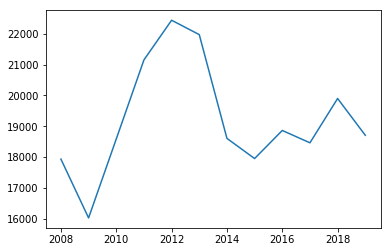

In [63]:
plt.plot(df_combined.groupby(['season'])['total'].sum())

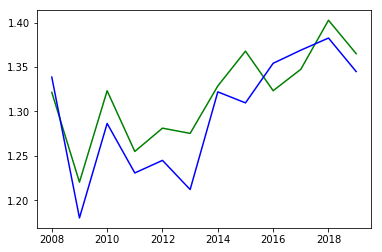

In [68]:
plt.plot(df_combined.query('level_0 == "inning_1"').groupby(['season'])['total'].mean(),color='green')
plt.plot(df_combined.query('level_0 == "inning_2"').groupby(['season'])['total'].mean(),color='blue')
plt.show()


In [70]:
df_combined.groupby(['batsman'])['batsman_runs'].sum()

batsman
A Ashish Reddy           266.0
A Chandila                 4.0
A Chopra                  53.0
A Choudhary               25.0
A Dananjaya                4.0
A Flintoff                62.0
A Kumble                  35.0
A Mishra                 362.0
A Mithun                  34.0
A Mukund                  19.0
A Nehra                   41.0
A Singh                    2.0
A Symonds                974.0
A Uniyal                   4.0
A Zampa                    5.0
AA Bilakhia               69.0
AA Chavan                 12.0
AA Jhunjhunwala          217.0
AA Noffke                  9.0
AB Agarkar               178.0
AB Barath                 42.0
AB Dinda                  26.0
AB McDonald              123.0
AB de Villiers          4356.0
AC Blizzard              120.0
AC Gilchrist            2065.0
AC Thomas                 20.0
AC Voges                 181.0
AD Hales                 148.0
AD Mascarenhas            52.0
                         ...  
V Pratap Singh             0.0
